In [59]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [42]:
url = "http://wfs.geonet.org.nz/geonet/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=geonet:quake_search_v1&outputFormat=json&cql_filter=magnitude>5+AND+eventtype=earthquake+AND+sortBy=magnitude"
response = requests.get(url)

In [108]:
features = response.json()['features']
df = pd.DataFrame(features)
geo_data = pd.json_normalize(df['geometry'])
prop_data = pd.json_normalize(df['properties'])
df = pd.concat([df, geo_data, prop_data], axis=1).drop(['geometry','properties'], axis=1)

In [109]:
quakes = (df[['origintime', 'depth', 'magnitude', 'coordinates']]
 .sort_values(by=['magnitude'], ascending=False)
 .head(150)
 )
quakes['longitude'] = quakes['coordinates'].apply(lambda x: x[0])
quakes['latitude'] = quakes['coordinates'].apply(lambda x: x[1])
quakes['origintime'] = pd.to_datetime(quakes['origintime'][:10])

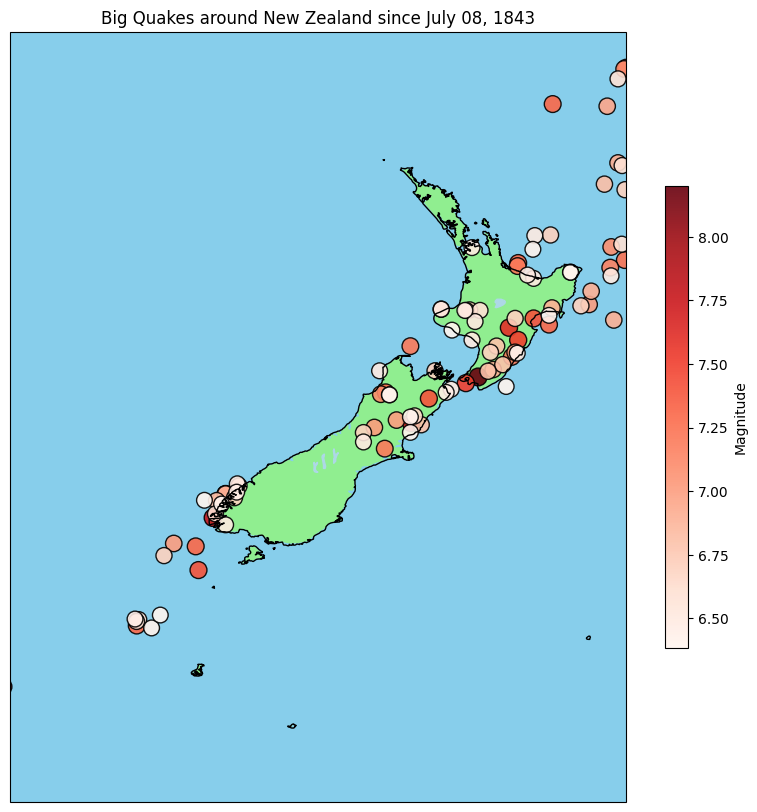

In [119]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([160, 180, -55, -30], crs=ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAKES, color='LightBlue')
# ax.add_feature(cfeature.RIVERS, color='LightBlue')
ax.add_feature(cfeature.LAND, color='LightGreen')
ax.add_feature(cfeature.OCEAN, color='SkyBlue')

scatter = ax.scatter(quakes['longitude'], quakes['latitude'], 
                     c=quakes['magnitude'], s=quakes['magnitude']*20, 
                     cmap='Reds', alpha=0.9, edgecolor='k', 
                     transform=ccrs.PlateCarree())

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.6, label='Magnitude')

since_date = quakes['origintime'].min().strftime('%B %d, %Y')
plt.title(f'Big Quakes around New Zealand since {since_date}')
plt.show()
